# Baseline CNN for Snake Idenfitifcation


In [1]:
# imports
import torch
import torchvision
import random
import matplotlib.pyplot as plt
import os
import copy
import torch.optim as optim
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from torchvision import datasets, models, transforms
from sklearn.metrics import f1_score
from PIL import Image

# debugging
os.environ['CUDA_LAUNCH_BLOCKING'] = '0'

In [19]:
DATA_DIR = "../../teams/DSC180A_FA20_A00/a01group09/"
TRAIN_DIR = "../../teams/DSC180A_FA20_A00/a01group09/train_snakes_r1/"
VAL_DIR = "../../teams/DSC180A_FA20_A00/a01group09/valid_snakes_r1/"

In [20]:
train_data = datasets.ImageFolder(TRAIN_DIR)

In [21]:
num_classes = len(train_data.classes) # exclude random ipynb nb

In [22]:
model_name = "densenet"
input_size = 224 # densenet specific input
batch_size = 16 # random number for now, can optimize later
feature_extract = False

In [23]:
# prepare data for neural network input
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]) 
}

In [24]:
image_datasets = {
    'train': datasets.ImageFolder(TRAIN_DIR, data_transforms['train']),
    'val': datasets.ImageFolder(VAL_DIR, data_transforms['val'])   
}
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 46374
     Root location: ../../teams/DSC180A_FA20_A00/a01group09/train_snakes_r1/
     StandardTransform
 Transform: Compose(
                Resize(size=224, interpolation=PIL.Image.BILINEAR)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 15428
     Root location: ../../teams/DSC180A_FA20_A00/a01group09/valid_snakes_r1/
     StandardTransform
 Transform: Compose(
                Resize(size=224, interpolation=PIL.Image.BILINEAR)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [25]:
# Create training and validation dataloaders
dataloaders_dict = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataloaders_dict

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f7a272f8bd0>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f7a272f8cd0>}

In [26]:
class_names = image_datasets['train'].classes # exclude random ipynb checkpoints

# Detect if we have a GPU available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

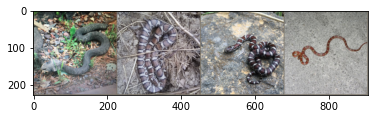

In [27]:
def imshow(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.pause(0.001)

# Get a mini-batch of training data
mini_batch = 4
dataloaders_dict_visualize = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=mini_batch, shuffle=True, num_workers=4) for x in ['train']}
inputs, classes = next(iter(dataloaders_dict_visualize['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out)

In [28]:
#Image.open(os.path.join(TRAIN_DIR, 'class-771/363ab4b2288f6018270cbbcd1bf801c9.jpg'))

In [35]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_fscore = 0.0
    
    loss_train_evo=[]
    acc_train_evo=[]
    fs_train_evo=[]
    
    loss_val_evo=[]
    acc_val_evo=[]
    fs_val_evo=[]
    
    total_train=round(47626/batch_size)

    for epoch in range(num_epochs):
        i = 0
        print('Epoch {}/{}'.format(epoch+1, num_epochs))

        # determine if train or val phase at each epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            fscore = []

            # iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients before backprop
                optimizer.zero_grad()

                # forward
                # track history if only in train

                with torch.set_grad_enabled(phase == 'train'):
                    """
                    if i==round(0.25*total_train):
                        print('Forward Passed 25%')
                    if i==round(0.5*total_train):
                        print('Forward Passed 50%')
                    if i==round(0.75*total_train):
                        print('Forward Passed 75%')
                    i = i + 1
                    """
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                labels_cpu = labels.cpu().numpy()
                predictions_cpu = preds.cpu().numpy()
                Fscore = f1_score(labels_cpu, predictions_cpu, average='macro')
                fscore.append(Fscore)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_fscore = np.average(np.array(fscore))
            
            print('{} Loss: {:.4f} Acc: {:.4f} F: {:.3f}'.format(phase, epoch_loss, epoch_acc, epoch_fscore))
            
            if phase == 'train':
                loss_train_evo.append(epoch_loss)
                epoch_acc = epoch_acc.cpu().numpy()
                acc_train_evo.append(epoch_acc)
                fs_train_evo.append(epoch_fscore)                
            else:
                loss_val_evo.append(epoch_loss)
                epoch_acc = epoch_acc.cpu().numpy()
                acc_val_evo.append(epoch_acc)
                fs_val_evo.append(epoch_fscore) 
                
            # deep copy the model
            if phase == 'val' and epoch_fscore > best_fscore:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_train_evo, acc_train_evo, fs_train_evo, loss_val_evo, acc_val_evo, fs_val_evo

# sets the .requires_grad attribute of the parameters in the model to False when we are feature extracting
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0

    model_ft = models.densenet121(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier.in_features
    model_ft.classifier = nn.Linear(num_ftrs, num_classes)
    input_size = 224

    return model_ft, input_size

In [36]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

In [37]:
# Send the model to GPU
model_ft = model_ft.to(device)

In [38]:
# check model in cuda 
next(model_ft.parameters()).is_cuda

True

In [39]:
params_to_update = model_ft.parameters()
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            # print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            a=1 # print("\t",name)
            
# Optimizer
optimizer_ft = optim.Adam(params_to_update, lr=3e-4)

# Loss Funciton
criterion = nn.CrossEntropyLoss()

In [40]:
num_epochs = 5
model_ft, loss_train, acc_train, fs_train, loss_val, acc_val, fs_val = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

In [44]:
# Save model
MODEL_DIR = os.path.join(DATA_DIR, 'model_states')
if not os.path.isdir(MODEL_DIR):
    os.mkdir(MODEL_DIR)
torch.save(model_ft.state_dict(), os.path.join(MODEL_DIR, 'baseline_model.pt'))

In [41]:
os.environ['CUDA_LAUNCH_BLOCKING']

'0'